# 2025 CAM6 PPE albedo symmetry study
These scripts were produced to produce the figures for the 2025 CAM6 PPE albedo symmetry study accepted for publication at Geophysical Research Letters.
Notebook finalized on 17 July 2025. All code produced by Aiden Jönsson.

In [ ]:
import cartopy as cp
import numpy as np
import scipy as sp
import xarray as xr
import pandas as pd
import seaborn as sns
import proplot as pplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import string

# Figure 1

The file `CERES_EBAF_Ed4.1_Subset_200003-202203.nc`is the monthly mean level CERES TOA data set, and the monthhs covering the July 2002-June 2021 period are selected below for the constraint; the data is not included here because of duplicate data hosting policies, but can be retrieved from the NASA LaRC website (`https://ceres.larc.nasa.gov/data/`).

In [ ]:
## PPE output
ppe_ds = xr.open_dataset("data/PPE_control_sim_fields.PD.20230612.nc")
zonmean_ds = xr.open_dataset("data/PPE_262_modeled_zonmean_SWfluxes.PD.20221117.nc")
lat = zonmean_ds.lat
weights = np.cos(np.deg2rad(lat))
NH = zonmean_ds.FSUTOA.where(lat>=0).weighted(weights).mean("lat")
SH = zonmean_ds.FSUTOA.where(lat<=0).weighted(weights).mean("lat")

## CERES EBAF
## Fields
ceres = xr.open_dataset("Data/CERES_EBAF_Ed4.1_Subset_200003-202203.nc").isel(time=slice(28,-9))
weights = ceres.time.dt.days_in_month
ceres = ceres.weighted(weights).mean("time").assign_coords(lon=(((ceres.lon + 180) % 360) - 180)).sortby("lon")
ceres = ceres.interp_like(ppe_ds)
ceres_SWCF = ceres.toa_sw_clr_c_mon - ceres.toa_sw_all_mon
ceres_FSUTOACS = ceres.toa_sw_clr_c_mon
ceres_FSUTOA = ceres.toa_sw_all_mon
ceres_CLDTOT = ceres.cldarea_total_daynight_mon/100

## Time weighted asymmetry
ceres = xr.open_dataset("Data/CERES_EBAF_Ed4.1_Subset_200003-202203.nc").isel(time=slice(28,-9))
weights = ceres.time.dt.days_in_month
lat_weights = np.cos(np.deg2rad(ceres.lat))
NH_SW = ceres_FSUTOA.where(ceres.lat>=0).weighted(lat_weights).mean(["lat","lon"]).copy()
SH_SW = ceres_FSUTOA.where(ceres.lat<=0).weighted(lat_weights).mean(["lat","lon"]).copy()
asym_mean = float((NH_SW - SH_SW).weighted(weights).mean())
asym_std = float((NH_SW - SH_SW).rolling(time=12).mean().std().item())

All SW cloud radiative feedbacks (SWCRF) for the PPE are estimated by taking the difference in global mean SW cloud radiative effect over the difference in global mean near-surface air temperatures between +4K SST and PD simulations. The emulated SWCRF are emulated directly.

In [ ]:
## Load emulator output and constrain with observed asymmetry
emu_asym = xr.open_dataarray("data/PPE_emulated_asymmetries.PD.20230607.nc")
emu_SWCRF = xr.open_dataarray("data/PPE_emulated_SWCRF.20231004.nc")
PPE_SWCRF = xr.open_dataarray("data/PPE_262_modeled_SWcloudfeedbacks.20231002.nc")
PPE_asyms = (NH - SH).copy()
asym_conds = (emu_asym <= asym_mean + asym_std) & (emu_asym >= asym_mean - asym_std)
constr_asym = emu_asym.where(asym_conds, drop=True)
asym_constr_SWCRF = emu_SWCRF.where(asym_conds, drop=True)

/opt/homebrew/anaconda3/envs/workenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/homebrew/anaconda3/envs/workenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


Figure(refwidth=2.5)

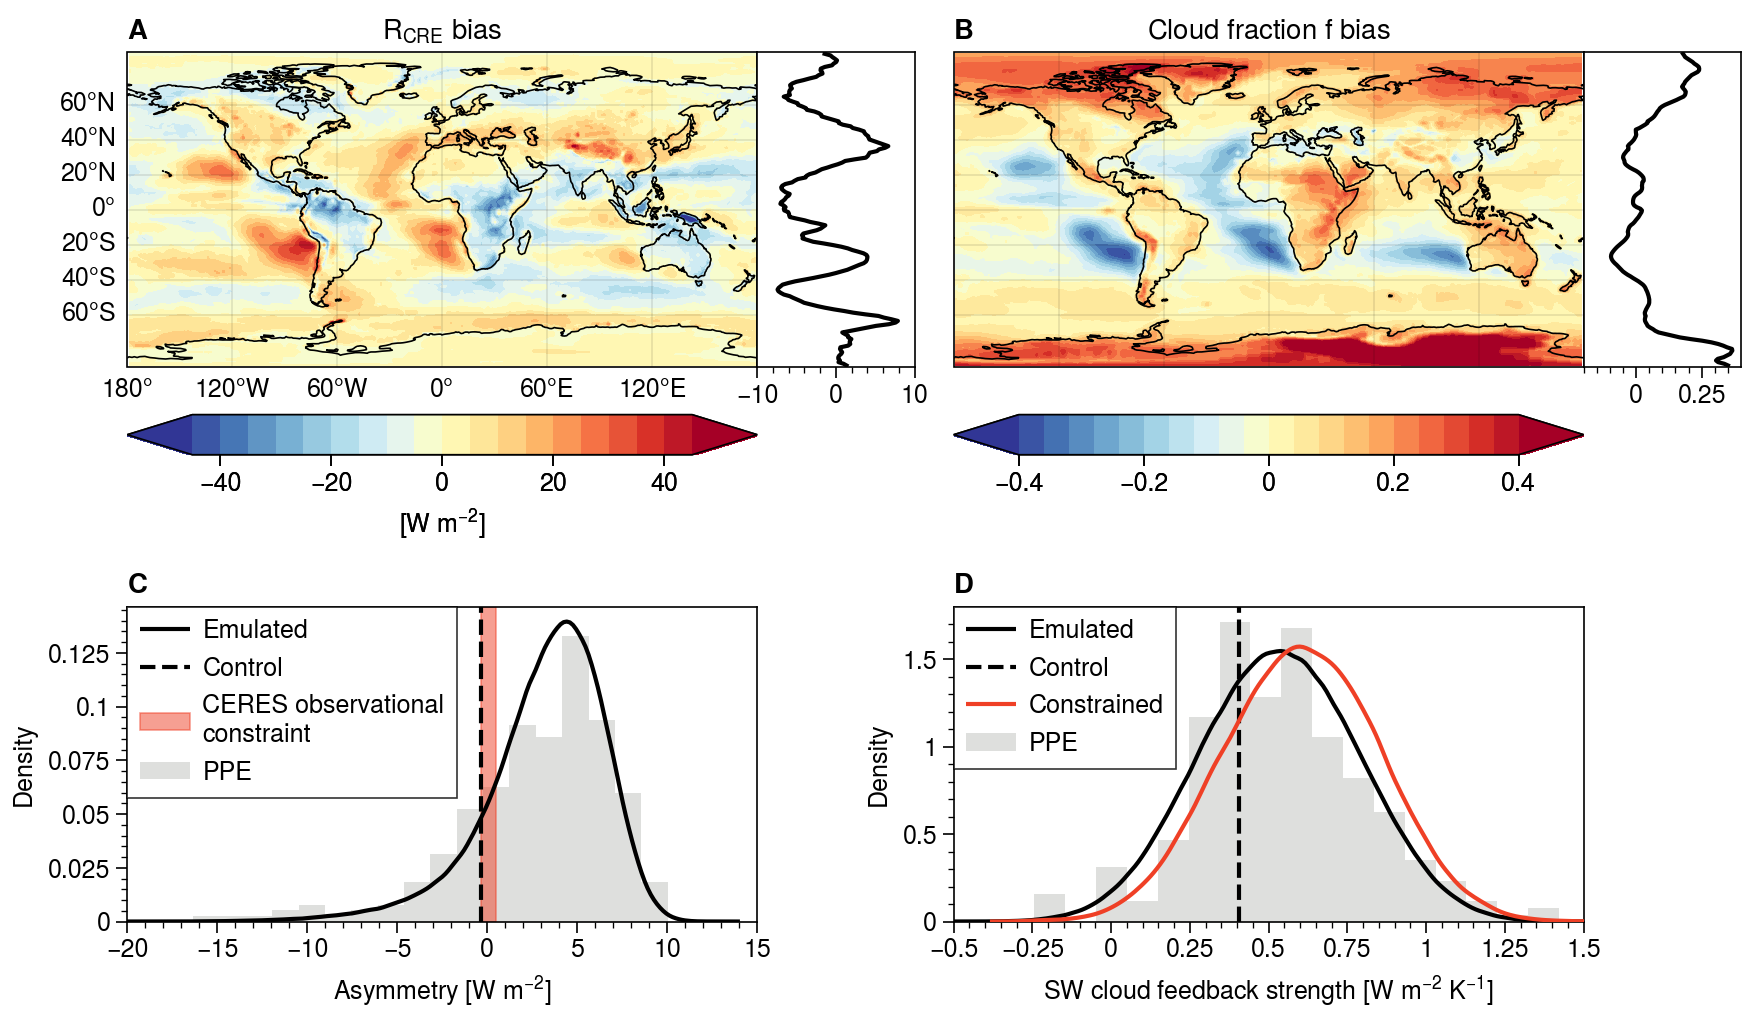

Figure(refwidth=2.5)

In [ ]:
fig = pplt.figure(refheight="4cm", facecolor="w", share=False)
gs = pplt.GridSpec(nrows=2, ncols=2)

variables = ["SWCF", "CLDTOT"]
labels = ["[$W\ m^{-2}$]", ""]
titles = ["$R_{CRE}$ bias", "Cloud fraction $f$ bias"]
xlims = [[-10, 10], [-.2, .4]]
vmaxes = [45, .4]
cticks = [np.arange(-40, 41, 20), np.arange(-.3, .31, .1)]
for n, var in enumerate(variables):
    
    data = (ppe_ds[var] - locals()["ceres_"+var])
    
    ## Map
    ax = fig.subplot(gs[0, n], proj="cyl", abc="A")
    ax.format(
        coast=True, abc="A", title=titles[n],
        latlines=np.arange(-60, 70, 20), lonlines=np.arange(-180, 181, 60),
    )
    if n==0: ax.format(labels=True)
    c = ax.contourf(
        data, cmap="BuYlRd", norm=mpl.colors.CenteredNorm(), levels=20,
        vmin=-vmaxes[n], vmax=vmaxes[n], extend="both"
    )
    ax.colorbar(c, label=labels[n], loc="b")
    
    ## Profile
    prof_ax = ax.panel("r", space=0, share=True, width="2cm")
    prof_ax.plot(data.mean("lon"), data.lat, c="k", zorder=10)
    prof_ax.format(
        grid=False, yticks=[], ylim=[-90, 90], ylabel="", xlabel="", xlim=xlims[n]
    )
    
    data = locals()["PPE_%s_spread" % var].control

    
ax = fig.subplot(gs[1, 0], grid=False)
ax.format(
    abc="A", xlabel="Asymmetry [$W\ m^{-2}$]", ylabel="Density", xlim=[-20, 15]
)
sns.histplot(PPE_asyms, ax=ax, stat="density", color="grey", lw=0, alpha=.3, label="PPE")
sns.kdeplot(emu_asym, ax=ax, color="k", fill=False, label="Emulated")
ax.axvspan(
    asym_mean - asym_std, asym_mean + asym_std,
    color="tomato", alpha=.5, label="CERES observational\nconstraint"
)
ax.axvline(PPE_asyms.values[0], color="k", ls="--", label="Control", zorder=5)
ax.legend(ncols=1, loc="ul")

ax = fig.subplot(gs[1, 1], grid=False)
ax.format(
    abc="A", xlabel="SW cloud feedback strength [$W\ m^{-2}\ K^{-1}$]",
    ylabel=r"", xlim=[-.5, 1.5]
)
sns.histplot(PPE_SWCRF, ax=ax, stat="density", color="grey", lw=0, alpha=.3, label="PPE")
sns.kdeplot(emu_SWCRF, ax=ax, c="k", label="Emulated")
ax.axvline(PPE_SWCRF.values[0], color="k", ls="--", label="Control", zorder=5)
sns.kdeplot(asym_constr_SWCRF, ax=ax, c="tomato", zorder=10, label="Constrained")
ax.legend(ncols=1, loc="ul")
    
fig.savefig("PPE_asym_Fig1_v3_revised.pdf")
pplt.figure()

In [39]:
## Print constraint range
quantile = asym_constr_SWCRF.quantile([.17, .83])
print("The constrained SW cloud feedback strengths are:")
print(
    "%s (%s-%s) W m-2 K-1" % (round(asym_constr_SWCRF.median().item(), 2), round(quantile[0].item(), 2), round(quantile[1].item(), 2))
)

The constrained SW cloud feedback strengths are:
0.61 (0.36-0.84) W m-2 K-1


# Figure 2

The pickles contain hemispheric mean values for historical simulation outputs from the CMIP models; these were calculated using cosine of latitude weighting for area averaging and month length in days weighting for time averaging, over the period 2000-2014.

In [ ]:
asym_covar_ds = xr.open_dataset("data/PPE_covariances_FSUTOA_asym.20230224.nc")
CMIP_asyms = (
    pd.read_pickle("data/CMIP/CMIP6_hist_NH_rsut.pkl") - \
    pd.read_pickle("data/CMIP/CMIP6_hist_SH_rsut.pkl")
).drop("FGOALS-f3-L", axis=1)
CMIP_LWP_asyms = (
    pd.read_pickle("data/CMIP/CMIP6_hist_NH_LWP.pkl") - \
    pd.read_pickle("data/CMIP/CMIP6_hist_SH_LWP.pkl")
).drop("FGOALS-f3-L", axis=1)
CMIP_CLDTOT_asyms = (
    pd.read_pickle("data/CMIP/CMIP6_hist_NH_clt.pkl") - \
    pd.read_pickle("data/CMIP/CMIP6_hist_SH_clt.pkl")
).drop("FGOALS-f3-L", axis=1)
CMIP_ice_frac_asyms = (
    pd.read_pickle("data/CMIP/CMIP6_hist_NH_ice_frac.20240108.pkl") - \
    pd.read_pickle("data/CMIP/CMIP6_hist_SH_ice_frac.20240108.pkl")
)
models = CMIP_asyms.columns.values.tolist()

In [ ]:
PPE_CLDTOT_HD = (
    xr.open_dataset("data/PPE_262_modeled_hemmean_CLDTOT.PD.20240108.nc").CLDTOT_NH - \
    xr.open_dataset("data/PPE_262_modeled_hemmean_CLDTOT.PD.20240108.nc").CLDTOT_SH
)
PPE_LWP_HD = (
    xr.open_dataset("data/PPE_262_modeled_hemmean_LWP.PD.20240108.nc").LWP_NH - \
    xr.open_dataset("data/PPE_262_modeled_hemmean_LWP.PD.20240108.nc").LWP_SH
)
PPE_ice_frac_HD = (
    xr.open_dataset("data/PPE_262_modeled_hemmean_FICE.PD.20240108.nc").ice_frac_NH - \
    xr.open_dataset("data/PPE_262_modeled_hemmean_FICE.PD.20240108.nc").ice_frac_SH
)

In [ ]:
def get_regression_line(x, y):
    
    from scipy import stats
    
    lin = stats.linregress(x, y)
    predict = lambda x : lin.slope * x + lin.intercept
    pred_x = np.linspace(np.min(x), np.max(x), len(x))
    pred_y = predict(pred_x)
    y_err = y - pred_y

    # Confidence intervals
    mean_x = np.mean(x)
    n = len(x)
    t = 2.31
    s_err = np.sum(np.power(y_err,2)) 
    confs = t * np.sqrt((s_err / (n - 2)) * (
        1. / n + (np.power((pred_x - np.mean(x)), 2) / ((np.sum(np.power(x,2))) - n * (np.power(np.mean(x), 2))))
    ))
    lower = pred_y - abs(confs)
    upper = pred_y + abs(confs)
    
    return pred_x, pred_y, lower, upper, lin

/Users/aiden/anaconda3/envs/workenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/aiden/anaconda3/envs/workenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/aiden/anaconda3/envs/workenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/aiden/anaconda3/envs/workenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate

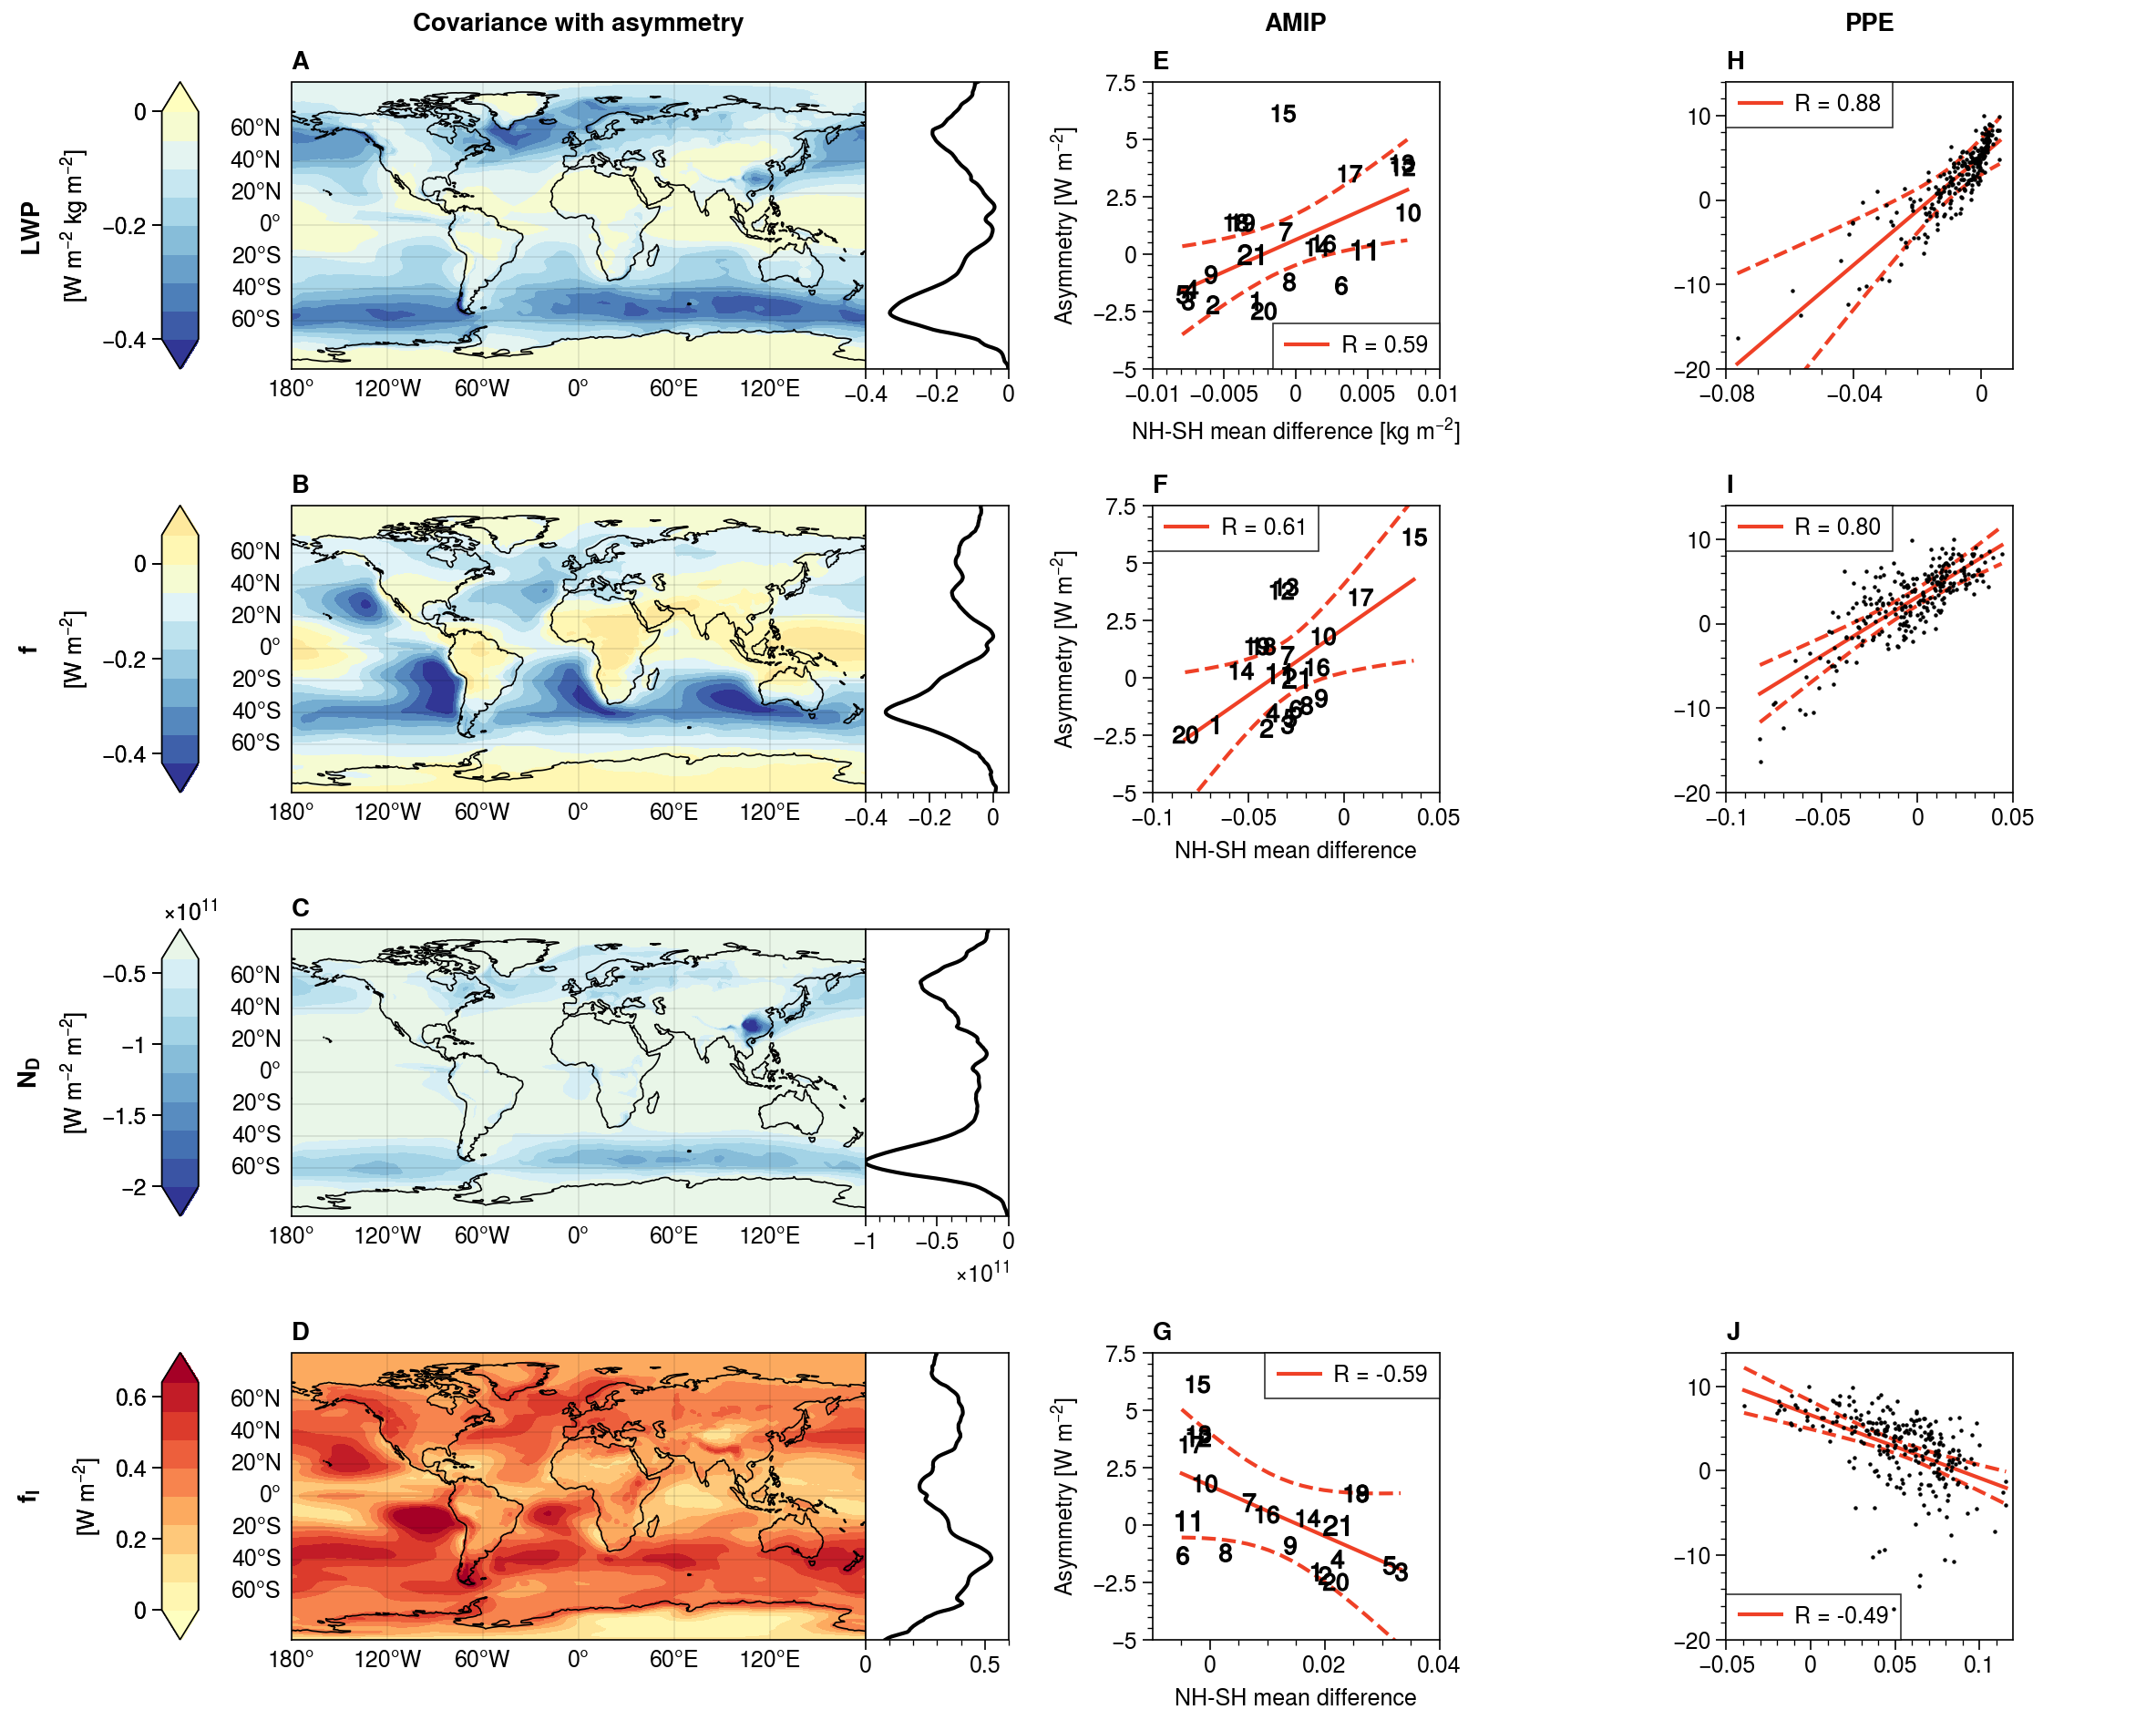

In [ ]:
variables = ["LWP", "CLDTOT", "CDNUMC", "ice_frac"]
labels = ["LWP", "$f$", "$N_D$", "$f_I$"]
units = {
    "SWCF":"$W\ m^{-2}$", "CLDTOT":"", "LWP":"$kg\ m^{-2}$",
    "CDNUMC":"$m^{-2}$", "ice_frac":""
}
scatter_units = {
    "SWCF":" [$W\ m^{-2}$]", "CLDTOT":"", "LWP":" [$kg\ m^{-2}$]",
    "CDNUMC":" [$m^{-2}$]", "ice_frac":""
}

fig = pplt.figure(refheight="4cm", facecolor="w", share=False)
gs = pplt.GridSpec(nrows=4, ncols=3, hspace=6)

clims = [[-.42, 0], [-.42, .1], [-2.1E11, -.4E11], [0, .7]]
cticks = [
    np.arange(-.4, 0.1, .2), np.arange(-.4, 0.1, .2), 
    np.arange(-2.E11, -.4E11, .5E11), np.arange(0, .7, .2)
]
xlims_col1 = [[-.4, 0], [-.4, .05], [-1E11, 0], [0, .6]]
xticks_col1 = [None, [-.4, -.2, 0], None, None]
amip_xlims = [
    [-.01, .01], [-.1, .05], None, [-.01, .04]
]
ppe_xlims = [[-.08, .01], [-.1, .05], None, [-.05, .12]]
counts = [1, 2, 3, 4]
for n, var in enumerate(variables):
    
    ## Covariance
    data = asym_covar_ds[var]
    ## Map
    ax = fig.add_subplot(gs[n, 0], proj="cyl")
    ax.number = counts[n]
    ax.format(
        coast=True, labels=True,
        latlines=np.arange(-60, 70, 20), lonlines=np.arange(-180, 181, 60)
    )
    c = ax.contourf(
        data, cmap="BuYlRd", norm=mpl.colors.CenteredNorm(), levels=10,
        extend="both", vmin=clims[n][0], vmax=clims[n][1]
    )
    if var in ["CLDTOT", "ice_frac"]: label = "[$W\ m^{-2}$]"
    else: label = "[$W\ m^{-2}\ $%s]" % units[var]
    ax.colorbar(c, label=label, loc="l", ticks=cticks[n])
    ## Profile
    prof_ax = ax.panel("r", space=0, share=True, width="2cm")
    prof_ax.plot(data.mean("lon"), data.lat, c="k", zorder=10)
    prof_ax.format(
        grid=False, yticks=[], ylim=[-90, 90], ylabel="", xlabel="", 
        xlim=xlims_col1[n], xticks=xticks_col1[n]
    )
    
    ## AMIP
    if var not in ["SWCF", "CDNUMC"]:
        ax = fig.add_subplot(gs[n, 1])
        if var=="ice_frac": axnumber = counts[n] + 3
        else: axnumber = counts[n] + 4
        ax.number = axnumber
        ax.set(box_aspect=1)
        for nm, m in enumerate(models):
            ax.scatter(
                locals()["CMIP_%s_asyms" % var][m].mean(),
                CMIP_asyms[m].mean(),
                marker=r"$ {} $".format(str(nm+1)), 
                c="k", s=50*len(str(nm+1)), lw=.5, zorder=100
            )
        
        y = CMIP_asyms.mean(axis=0)
        x = locals()["CMIP_%s_asyms" % var].mean(axis=0)
        pred_x, pred_y, lower, upper, lin = get_regression_line(x, y)
        ax.plot(pred_x, pred_y, c="tomato", label="R = %.2f" % lin.rvalue)
        ax.plot(pred_x, lower, c="tomato", ls="--")
        ax.plot(pred_x, upper, c="tomato", ls="--")
        ax.legend()
        ax.format(
            xlabel="NH-SH mean difference" + scatter_units[var], xlim=amip_xlims[n],
            ylabel="Asymmetry [$W\ m^{-2}$]", ylim=[-5, 7.5], grid=False,
        )
        
        ## PPE space
        pax = fig.add_subplot(gs[n, 2])
        pax.set(box_aspect=1)
        if var=="ice_frac": axnumber = counts[n] + 6
        else: axnumber = counts[n] + 7
        pax.number = axnumber
        y = PPE_asyms.values
        x = locals()["PPE_%s_HD" % var].values
        pred_x, pred_y, lower, upper, lin = get_regression_line(x, y)
        pax.plot(pred_x, pred_y, c="tomato", label="R = %.2f" % lin.rvalue)
        pax.plot(pred_x, lower, c="tomato", ls="--")
        pax.plot(pred_x, upper, c="tomato", ls="--")
        pax.legend()
        pax.scatter(x, y, c="k", s=1, zorder=100)
        pax.format(grid=False, ylim=[-20, 14], xlim=ppe_xlims[n])
        if n==0: pax.format(xticks=np.arange(-.08, .03, .04))


fig.format(
    rowlabels=labels, abc="A",
    collabels=["Covariance with asymmetry", "AMIP", "PPE"],
)

fig.savefig("PPE_asym_Fig2_v2.pdf", dpi=300, bbox_inches="tight")
pplt.show()

# Figure 3

In [ ]:
fig = pplt.figure(refheight="4cm", facecolor="w", share=False)
gs = pplt.GridSpec(nrows=3, ncols=3, hspace=[None, "3.5cm"])

cov_ds = xr.open_dataset(
    "data/PPE_parameter_covariances_FSUTOA.PD.20230627.nc"
)
params = [
    "micro_mg_autocon_lwp_exp", "micro_mg_autocon_nd_exp", 
    "zmconv_c0_ocn", "zmconv_ke_lnd", "clubb_C2rt", "microp_aero_wsubi_min",
    "clubb_c14", "clubb_C6rtb", "seasalt_emis_scale"
]
param_short = [
    "M1", "M2", "Z1", "Z3", "C1", "A1", "C2", "C3", "A2"
]
xlims = [[0, 8], [-4, 0], [-1, 1],  [0, 2], [-2, 2], [-1, 1]]
for n, param in enumerate(params[:6]):

    data = cov_ds[param]
    
    ## Map
    ax = fig.subplot(gs[n], proj="cyl", abc="A")
    ax.format(
        coast=True, abc="A", title=param + " (%s)" % param_short[n],
        #latlines=np.arange(-60, 70, 20), lonlines=np.arange(-180, 181, 60)
    )
    c = ax.contourf(
        data, cmap="RdYlBu_r", norm=mpl.colors.CenteredNorm(), levels=10
    )
    ax.colorbar(c, label="[$\mathrm{W\ m^{-2}}$]", loc="b", pad=1)

    ## Profile
    prof_ax = ax.panel("r", space=0, share=True, width="2cm")
    prof_ax.plot(data.mean("lon"), data.lat, c="k", zorder=10)
    prof_ax.format(
        grid=False, yticks=[], ylim=[-90, 90], ylabel="", xlabel="", xlim=xlims[n]
    )
    
fig.text(.5, .997, "Precipitation", fontsize=18, weight="bold", ha="center", va="center")

xlims = [[-4, 0], [None, None], [0, 2.25]]
for n, param in enumerate(params[6:]):

    data = cov_ds[param]
    
    ## Map
    ax = fig.subplot(gs[6+n], proj="cyl", abc="A")
    ax.format(
        coast=True, abc="A", title=param + " (%s)" % param_short[n],
        #latlines=np.arange(-60, 70, 20), lonlines=np.arange(-180, 181, 60)
    )
    c = ax.contourf(
        data, cmap="RdYlBu_r", norm=mpl.colors.CenteredNorm(), levels=10
    )
    ax.colorbar(c, label="[$\mathrm{W\ m^{-2}}$]", loc="b", pad=1)

    ## Profile
    prof_ax = ax.panel("r", space=0, share=True, width="2cm")
    prof_ax.plot(data.mean("lon"), data.lat, c="k", zorder=10)
    prof_ax.format(
        grid=False, yticks=[], ylim=[-90, 90], ylabel="", xlabel="", xlim=xlims[n]
    )
    
fig.text(.35, .32, "Turbulence", fontsize=18, weight="bold", ha="center", va="center")
fig.text(.84, .32, "Sea salt aerosols", fontsize=18, weight="bold", ha="center", va="center")

fig.savefig("plots/PPE_asym_Fig3_rev.pdf", bbox_inches="tight")